In [32]:
import mdp
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from numpy.random import *
import scipy as sp
import scipy.misc
from skimage.draw import line_aa
import numpy as np
from skimage.draw import line_aa
import seaborn as sns
import time

In [219]:
#filters

filters = [[[0,1],[1,0]], 
           [[1,0],[0,1]], 
           [[1,0],[1,0]], 
           [[0,1],[0,1]], 
           [[1,1],[0,0]], 
           [[0,0],[1,1]]]

def self_mult(row):
    x = row[:,None]
    return np.dot(x, x.T)

def angles(img, filters=filters):
    filtered = np.zeros((len(filters), *img.shape))

    for _, f in enumerate(filters):
        filtered[_] = sp.signal.convolve(img, f, mode='same', method='direct')

    filtered_vectors = filtered.reshape((filtered.shape[0], filtered.shape[1]*filtered.shape[2]))
    all_corr = np.apply_along_axis(self_mult, 1, filtered_vectors)

    connect = np.max(all_corr, axis=0) #remove self-connections???
    return np.log(connect+1)

In [218]:
#drawing lines

def random_line(height, width):
    rr, cc, _ = line_aa(np.random.choice(range(height)), np.random.choice(range(width)), np.random.choice(range(height)), np.random.choice(range(width)))
    return rr, cc

def horizontal_line(height, width):
    h = np.random.choice(range(height))
    rr, cc, _ = line_aa(h, np.random.choice(range(width)), h, np.random.choice(range(width)))
    return rr, cc
    
def vertical_line(height, width):
    w = np.random.choice(range(width))
    rr, cc, _ = line_aa(np.random.choice(range(height)), w, np.random.choice(range(height)), w)  
    return rr, cc

**The Izhikevich Model**

(1) dv/dt = 0.04v^2 + 5v + 140 - u + I\
(2) du/dt = a(bv-u)\
(3) if v = 30mV, then: v <- c; u <- u+d

**where:**\
v = membrane potential \
u = recovery variable \
a = time scale of recovery \
b = sensitivity of recovery to subthreshold oscillations \
c = after-spike reset value of v \
d = after-spike reset increment of u 

In [244]:
def timeStep(a,b,c,d,v,u,i,thresh=30,substeps=2):
    """ worker function for simulation. given parameters and current state variables, compute next ms """
    
    fired = v>thresh     # array of indices of spikes
    print('fired', sum(fired))
    v1 = v             # next step of membrane potential v
    u1 = u             # next step of recovery variable u
    #spikesum = sum(fired), sum(fired[:Ne]), sum(fired[Ne:])
    
    ### Action potentials ###
    v[fired] = thresh
    v1[fired] = c[fired]                # reset the voltage of any neuron that fired to c
    u1[fired] = u[fired] + d[fired]     # reset the recovery variable of any neuron that fired to u_0 + d
    i1 = i + sum(S[:,fired],axis=1)    # sum spontanous thalamic input and weighted inputs from all other neurons
    
    ### Step forward ###
    for i in range(substeps):  # for numerical stability, execute at least two substeps per ms
        v1 += (1.0/substeps)*(0.04*(v1**2)+(5*v1)+140-u+i1) # 
        u1 += (1.0/substeps)*a*(b*v1-u1)
    return v1, u1, i1, fired

def simulate(a,b,c,d,v0,u0,length,verbose=True):
    global It, I, Itrace, img
    """ input:
    - for each of N neurons: parameters a,b,c,d, initial voltage v0 and recovery variables u0
    - length of simulation in milliseconds
    - NxN synaptic weight matrix
    
    processing:
        - simulates network evolution with spike-timing-dependent plasticity
    
    output:
        - Nxlength matrix of membrane voltages v over time
        - Nxlength matrix of recovery variables u over time
        - Nxlength matrix of synaptic inputs i over time
    """
    vout = np.zeros((N,length),dtype=double)
    vout[:,0] = v                                          # initial voltages
    uout = np.zeros((N,length),dtype=double)
    uout[:,0] = u
    iout = np.zeros((N,length),dtype=double)               # synaptic input matrix
    iout[:,0] = np.concatenate((5*rand(Ne),2*rand(Ni)))  # random thalamic input
    
    t0 = time.clock()
    
    ## simulate
    for t in range(1,length):
        AI = np.concatenate((rand(Ne), rand(Ni))) # thalamic input
        #AI[:Ne] += img.reshape((N,))[:Ne] # NEW
        #AI[-Ni:] -= img.reshape((N,))[-Ni:] # NEW
        
        AI = AI > 0.7
        It += AI
        It = It - It*decay
        Itrace[t,:] = It
        
        vout[:,t],uout[:,t],iout[:,t],firings[t][1] = timeStep(a,b,c,d,vout[:,t-1],uout[:,t-1],It)
        firings[t][0] = t
        #I = It+sum(S[:,firings[t][1]],2)
        
        # report progress
        if verbose and t % 100 == 0:
            print("Simulated " + str(t) + "ms of braintime in " + str(time.clock()-t0) + "s of computer time.") 
    
    t1 = time.clock()
    print("Simulation took " + str((t1-t0)) + "s")
    return vout,uout,iout

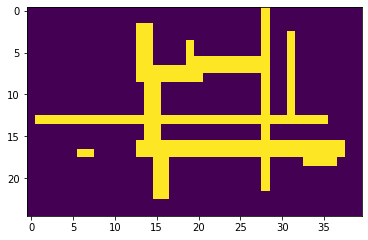

In [220]:
#image generation
height, width = 25, 40
img = np.zeros(shape=(height,width))

for i in range(3):
    img[random_line(height, width)] = 1
    img[horizontal_line(height, width)] = 1
    img[vertical_line(height, width)] = 1

plt.imshow(img)
plt.show()

In [245]:
length = 1000    # simulation time in ms
N = height * width # total number of neurons
Ne = int(N * 0.8)      # number of excitatory neurons
Ni = N - Ne       # number of inhibitory neurons
print(N, 'neurons in total', Ne, Ni)
S = np.concatenate((0.5*rand(N,Ne), -0.9*rand(N,Ni)),axis=1)  #initial synaptic weights
S_angles = angles(img) #connecting neurons with same angles
S *= S_angles

firings = np.zeros((length,2,N))
re = np.array(rand(Ne),dtype=double)  # uniformly distributed random doubles [0,1)
ri = np.array(rand(Ni),dtype=double)  # uniformly distributed random doubles [0,1)
    
a = np.concatenate((0.02+0.001*re,0.02+0.02*ri))     # a = time scale of recovery
b = np.concatenate((0.2+0.001*re, 0.25-0.05*ri))     # b = sensitivity of recovery to subthreshold oscillations
c = np.concatenate((-65+5*(re**2),-65+0.5*(ri**2)))  # c = after-spike reset value of v
d = np.concatenate((8-6*(re**2),  2+0.5*(ri**2)))    # d = after-spike reset increment of u
v = -65.0 * np.ones(N,dtype=double) # Initial values of v
u = b*v    # Initial values of u
    
I = (5*np.random.normal(size=(Ne)), 2*np.random.normal(size=(Ni))) # thalamic input
I = np.concatenate(I)

#I *= img.reshape((N,)) #add random spikes to 

It = I*0
Itrace  = np.zeros(shape=(length, N))
decay = 0.1

vo, uo, io = simulate(a,b,c,d,v,u,length,verbose=True)

1000 neurons in total 800 200
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 2
fired 4
fired 6
fired 6
fired 9
fired 1
fired 2
fired 0
fired 1
fired 1
fired 4
fired 1
fired 1
fired 2
fired 4
fired 4
fired 5
fired 1
fired 4
fired 2
fired 6
fired 0
fired 0
fired 2
fired 4
fired 5
fired 3
fired 8
fired 7
fired 6
fired 15
fired 3
fired 4
fired 1
fired 1
fired 2
fired 1
fired 0
fired 2
fired 10
fired 5
fired 2
fired 15
fired 17
fired 14
fired 12
fired 14
fired 5
fired 8
fired 12
fired 12
fired 15
fired 15
fired 27
fired 31
fired 42
fired 77
fired 106
fired 199
fired 321
fired 530
fired 470
fired 583
fired 417
fired 560


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


fired 440
fired 389
fired 607
fired 995
fired 570
fired 430
fired 202
fired 686
fired 836
fired 164
fired 408
fired 60
fired 10
fired 1
fired 1
fired 0
fired 1
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
Simulated 100ms of braintime in 0.13977350000004662s of computer time.
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 1
fired 1
fired 1
fired 1
fired 0
fired 1
fired 1
fired 2
fired 0
fired 0
fired 0
fired 0
fired 2
fired 3
fired 1
fired 3
fired 3
fired 3
fired 1
fired 3
fired 2
fired 2
fired 1
fired 0
fired 1
fired 1
fired 3
fired 1
fired 0
f

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [246]:
vo1 = vo.copy()
vo1[vo1 > 30] = 30

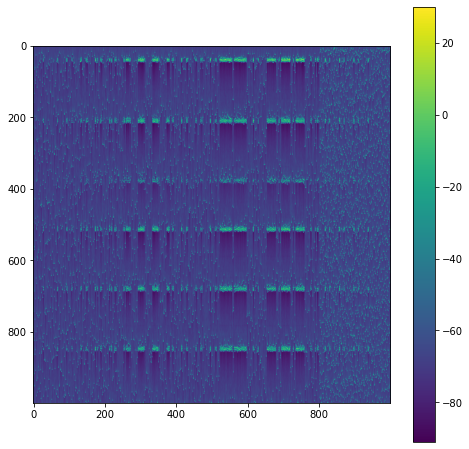

In [236]:
h, w = vo1.shape #firings[:,1]

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(vo1.T) #firings[:,1]
plt.colorbar()

ax.set_aspect(w/h)
plt.show()